<a href="https://colab.research.google.com/github/Jeet1309/Alzheimer-s-Detection/blob/main/Copy_of_Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeetgurbani","key":"a02696361cdb7a16a07e42a16004510a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy

Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0


In [ ]:
!unzip best-alzheimer-mri-dataset-99-accuracy.zip


Streaming output truncated to the last 5000 lines.
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1106).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1107).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1108).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1109).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (111).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1110).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1111).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1112).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1113).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1114).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1115).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1116).jpg  
  inflating: Combined Dataset/train/No

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import seaborn as sns
from PIL import Image
from pathlib import Path
import tensorflow as tf
from random import randint
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd


In [ ]:
dataset_dir = '/content/Combined Dataset/train'
img_height, img_width = 128, 128
batch_size = 32
seed = 42

# Load image paths and labels, excluding "Very Mild Impairment"
filepaths = []
labels = []

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(class_name)

# Create dataframe
df = pd.DataFrame({
    'filename': filepaths,
    'class': labels
})

# Split the dataset: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['class'], random_state=seed)

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=seed
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=seed
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=seed
)


Found 8192 validated image filenames belonging to 4 classes.
Found 1024 validated image filenames belonging to 4 classes.
Found 1024 validated image filenames belonging to 4 classes.


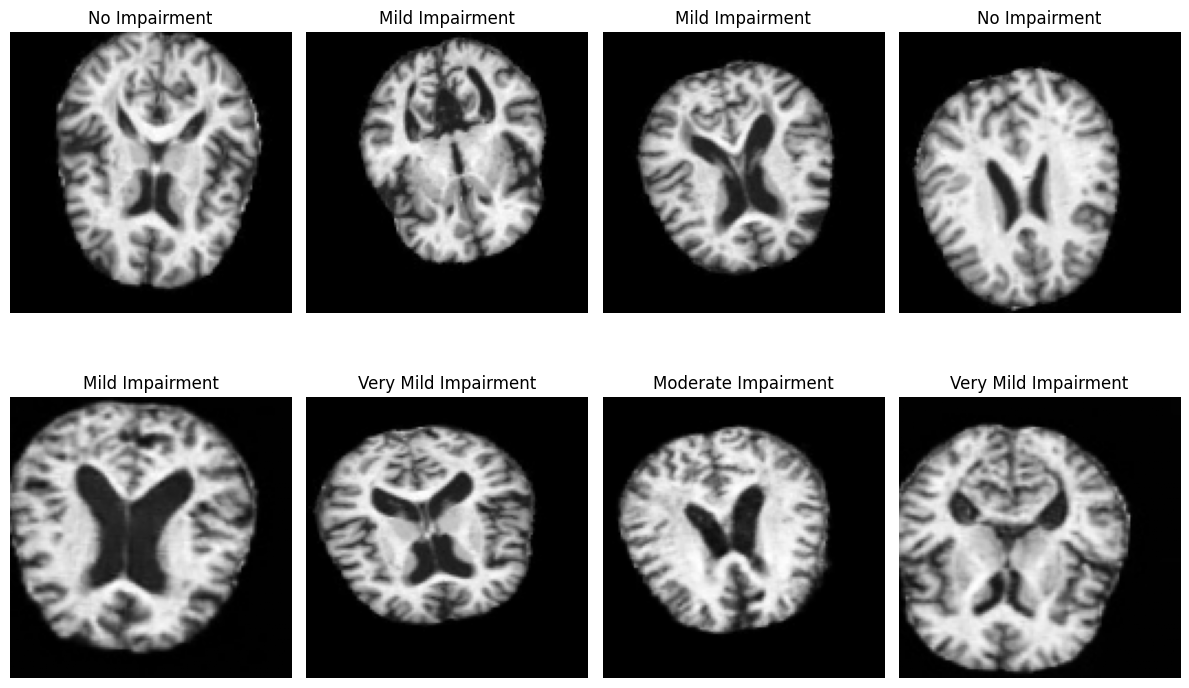

In [ ]:
class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)  # Get one batch

plt.figure(figsize=(12, 8))
for i in range(8):  # Show 8 images
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # squeeze in case of (128,128,1)
    label_idx = np.argmax(labels[i])
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
model = Sequential([
    Input(shape=(128,128, 1)),
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same', name = 'last_conv_layer'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')
], name = "cnn_model")



In [ ]:
OPT = tf.keras.optimizers.RMSprop()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.F1Score()]

model.compile(optimizer=OPT,
              loss='categorical_crossentropy',
              metrics=METRICS)

# Summary
model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 3,355,060 (12.80 MB)

 Trainable params: 3,352,692 (12.79 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss',
                              mode = 'min',
                              patience = 80,
                              verbose = 1)

filepath = './best2.weights.h5'

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_loss',
                                mode='min',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:


# Train
history = model.fit(
    train_generator,
    epochs=90,
    validation_data=val_generator,
    callbacks=callback_list
)

# Save
model.save('alzheimers_cnn_model.h5')

Epoch 1/90


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - acc: 0.2710 - auc: 0.5331 - f1_score: 0.2704 - loss: 1.8917
Epoch 1: val_loss improved from inf to 5.07996, saving model to ./best2.weights.h5
256/256 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - acc: 0.2711 - auc: 0.5332 - f1_score: 0.2705 - loss: 1.8910 - val_acc: 0.2480 - val_auc: 0.5164 - val_f1_score: 0.1001 - val_loss: 5.0800
Epoch 2/90
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - acc: 0.3973 - auc: 0.6671 - f1_score: 0.3918 - loss: 1.3465
Epoch 2: val_loss did not improve from 5.07996
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - acc: 0.3974 - auc: 0.6672 - f1_score: 0.3919 - loss: 1.3463 - val_acc: 0.3086 - val_auc: 0.5846 - val_f1_score: 0.2007 - val_loss: 5.2123
Epoch 3/90
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.5001 - auc: 0.7685 - f1_score: 0.4778 - loss: 1.1240
Epoch 3: val_loss improved from 5.07996 to 1.50013, saving model to ./best2.weights.h5
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - acc: 0.5002 - auc: 0.7686 - f1_score: 

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy: 0.8965
Weighted F1-score: 0.8942

Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.91      0.98      0.94       256
 Moderate Impairment       1.00      1.00      1.00       256
       No Impairment       0.96      0.69      0.80       256
Very Mild Impairment       0.77      0.92      0.84       256

            accuracy                           0.90      1024
           macro avg       0.91      0.90      0.89      1024
        weighted avg       0.91      0.90      0.89      1024



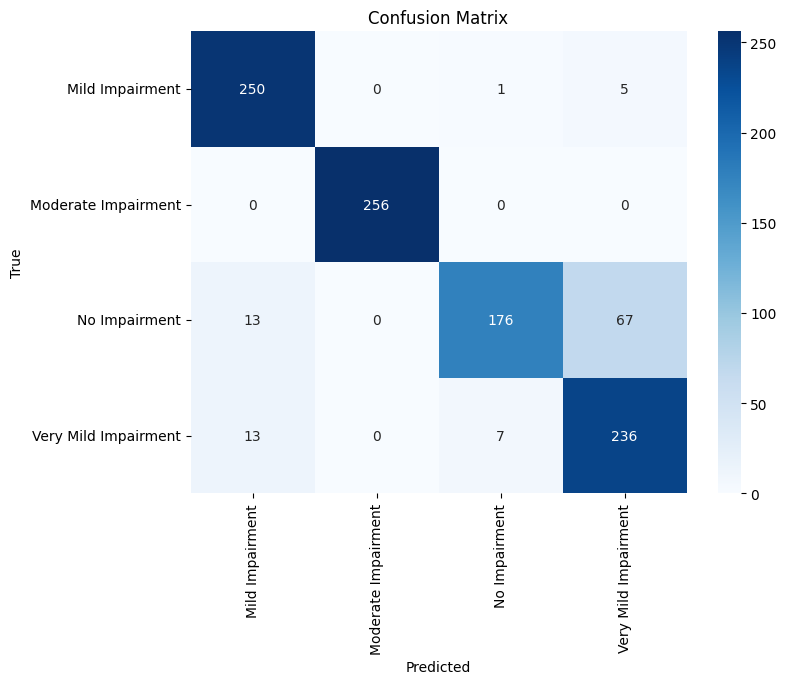

In [ ]:
model.load_weights(filepath)

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

# Class labels
class_names = list(test_generator.class_indices.keys())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1-score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


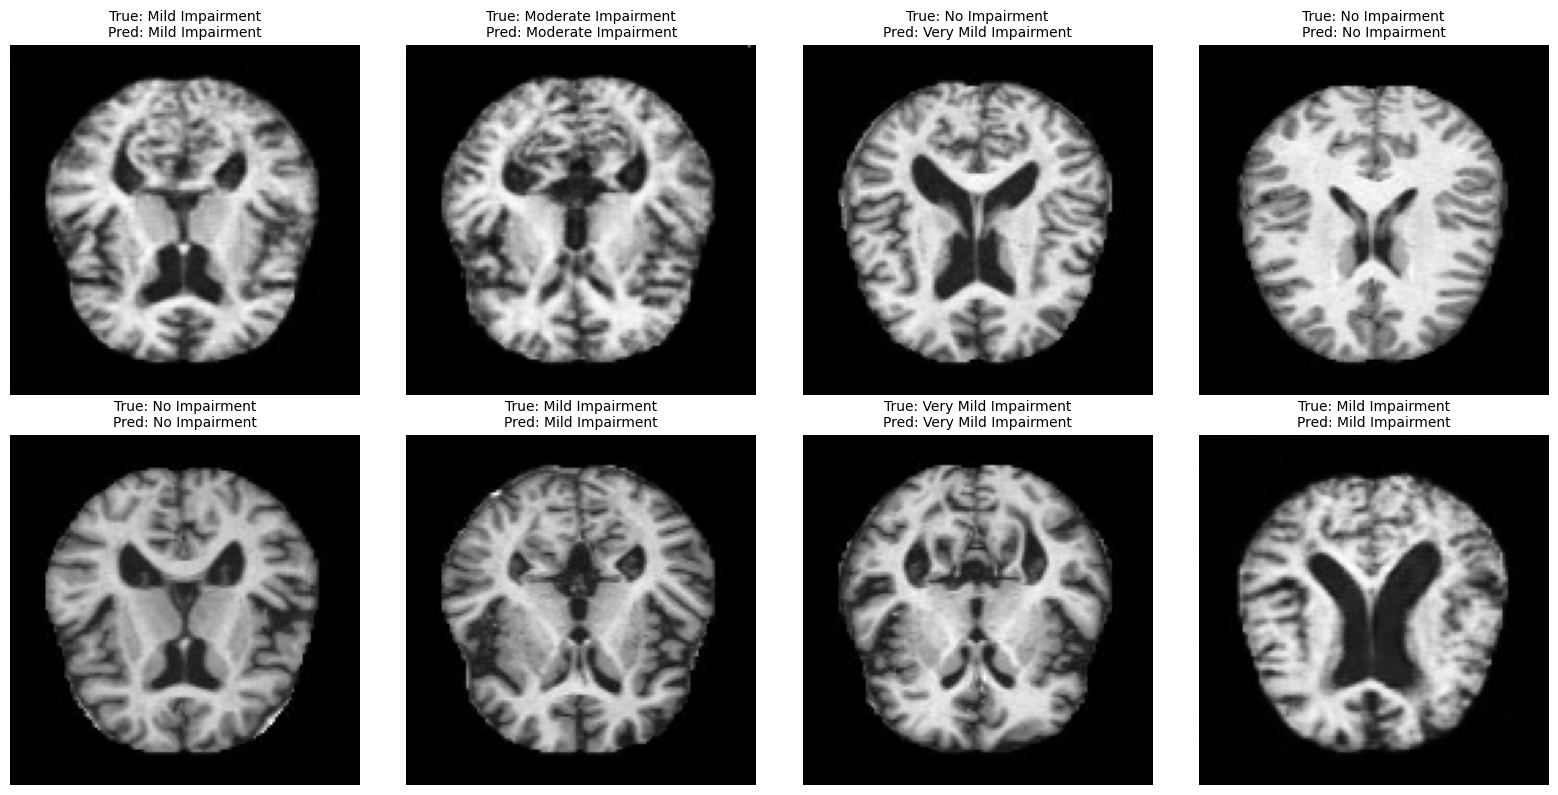

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())
file_paths = test_generator.filepaths

# Pick 8 random indices
random_indices = random.sample(range(len(file_paths)), 8)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(random_indices):
    img_path = file_paths[idx]

    # Load image in grayscale
    img = tf.keras.preprocessing.image.load_img(
        img_path,
        target_size=(img_height, img_width),
        color_mode='grayscale'
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, axis=0)  # Shape becomes (1, height, width, 1)

    # Make prediction
    pred = model.predict(img_array, verbose=0)
    pred_label = class_names[np.argmax(pred)]
    true_label = class_names[true_classes[idx]]

    # Plotting
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.squeeze(img_array[0]), cmap='gray')  # Show grayscale image
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

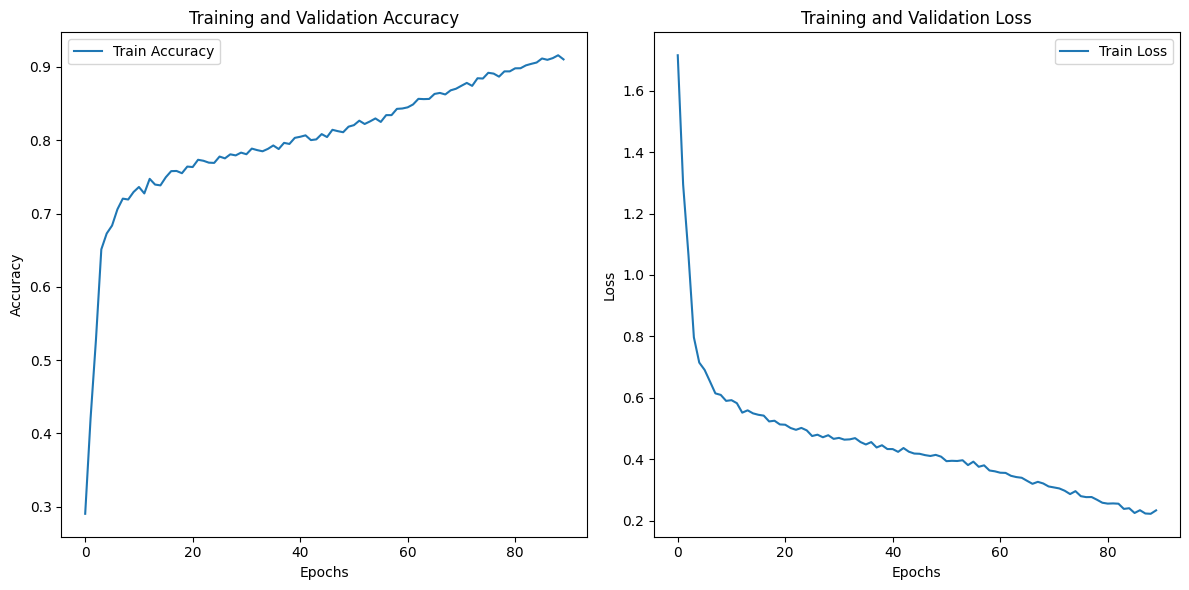

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')             # ← updated
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


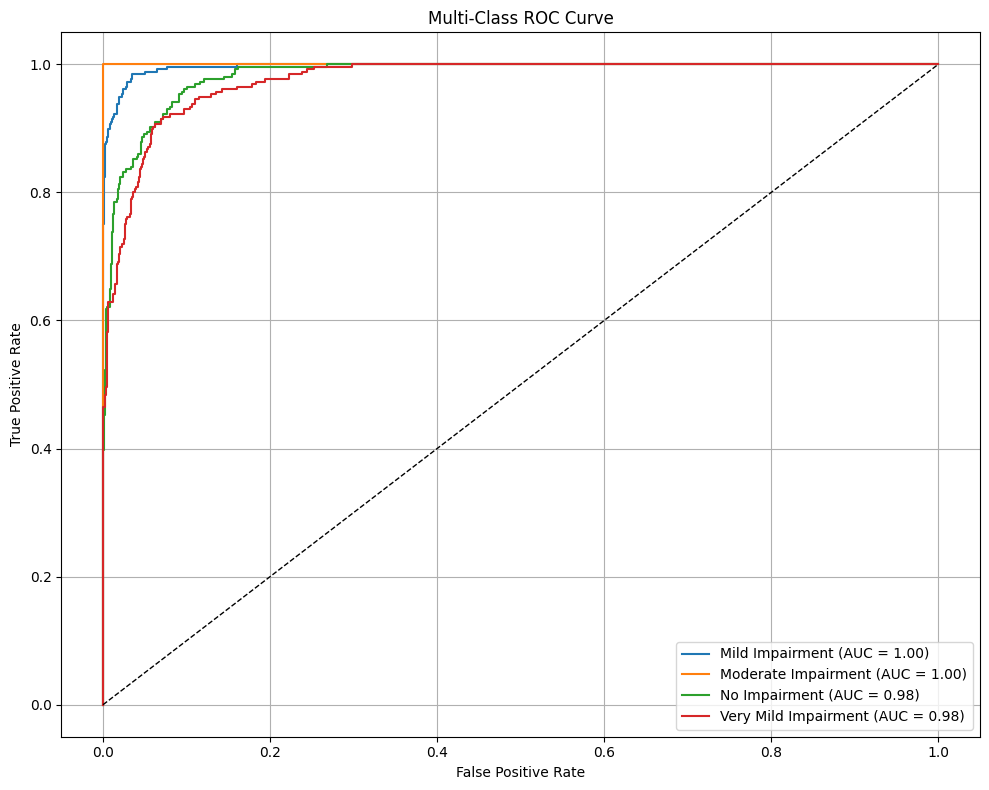

In [ ]:
y_pred_proba = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Binarize the labels for multi-class AUC
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Plot setup
plt.figure(figsize=(10, 8))

# Compute and plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
